In [77]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
import numpy as np
import time
import scipy.io

In [78]:
#numbers describing the bci data
num_features = 64
number_of_people = 6
bci_channel_count = 11

#settings
data_name = "Fear"
use_bci_features = False

In [79]:
#load bci feature and questoinnaire data from matlab files
def flatten_bci_feature_data(raw_data, num_features):
    data_size_x = int(raw_data.shape[0] / num_features)
    data_size_y = num_features * bci_channel_count

    data = np.array([])

    for person_index in range(0, number_of_people):
        temp_data = np.zeros((data_size_x, data_size_y))

        for i in range(temp_data.shape[0]):
            lr = i * num_features
            ur = (i + 1) * num_features
            temp_data[i] = raw_data[lr:ur, :, person_index].flatten('F')

        #pdb.set_trace()
        data = temp_data if person_index == 0 else np.append(data, temp_data, axis=0)

    return data


def process_raw_bci_data(data_raw, num_input):
    #We are going to apply minmax normalization separately for each channel for each person
    for person_index in range(data_raw.shape[2]):
        for channel_index in range(data_raw.shape[1]):
            values = data_raw[:, channel_index, person_index]
            data_raw[:, channel_index, person_index] = (values - values.min()) / (values.max() - values.min())

    data_size_x = int(data_raw.shape[0] / num_input)
    data_size_y = num_input * bci_channel_count

    data = np.zeros((data_size_x, data_size_y))

    for i in range(data.shape[0]):
        lr = i * num_input
        ur = (i + 1) * num_input
        data[i] = data_raw[lr:ur, :, person_index].flatten('F')

        #minmax normalization
        #data[i] = (data[i] - data[i].min()) / (data[i].max() - data[i].min())

    return data


def stretch_arr(arr, length):
    repeat = np.repeat(arr, length // len(arr) + 1)
    return repeat[-length:]


#there are only ~27 values for the moving average (which will be "strected" to the number of rows BCI data)
def process_mov_avg_data(data_raw, num_rows_bci_data):
    #MinMax normalization
    data_raw = (data_raw - data_raw.min()) / (data_raw.max() - data_raw.min())

    return stretch_arr(data_raw, num_rows_bci_data)


num_features = 64 if use_bci_features else 512

#"bci_feature_data" is x, questionnaire_data is y
bci_feature_data = np.array(
    scipy.io.loadmat(f"encoded_data_{data_name}.mat")["data"]) if use_bci_features else np.array(
    scipy.io.loadmat("Data.mat")["Data"][data_name][0][0]) / 10000
bci_feature_data = flatten_bci_feature_data(bci_feature_data, num_features)

questionnaire_data = scipy.io.loadmat("Questionnaire.mat")["Questionnaire"][f"{data_name}MovingAverage"][0][0]
questionnaire_data = np.array(questionnaire_data)
questionnaire_data = process_mov_avg_data(questionnaire_data, bci_feature_data.shape[0])

#"smooth" out survey data using savgol filter
window_size = 11
poly_order = 3
questionnaire_data = savgol_filter(questionnaire_data, window_size, poly_order)

In [80]:
#method for building prediction model
def build_model(input_length):
    network = models.Sequential()

    network.add(layers.Dense(256, activation="relu", input_shape=(input_length,)))
    #network.add(layers.Dropout(0.5))
    network.add(layers.Dense(128, activation="relu"))
    #network.add(layers.Dropout(0.5))
    network.add(layers.Dense(64, activation="relu"))
    #network.add(layers.Dropout(0.5))
    network.add(layers.Dense(32, activation="relu"))
    network.add(layers.Dense(1))

    network.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

    return network

---------- CROSS FOLD VALIDATION ----------

---------------------- FOLD NO 1 TRAINING BEGIN ----------------------

Epoch 1/10
372/372 [==============================] - 4s 10ms/step - loss: 0.7377 - mae: 0.3874
Epoch 2/10
372/372 [==============================] - 3s 9ms/step - loss: 0.0726 - mae: 0.2006
Epoch 3/10
372/372 [==============================] - 3s 8ms/step - loss: 0.1336 - mae: 0.2172
Epoch 4/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0439 - mae: 0.1528
Epoch 5/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0314 - mae: 0.1317
Epoch 6/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0321 - mae: 0.1337
Epoch 7/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0326 - mae: 0.1373
Epoch 8/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0321 - mae: 0.1332
Epoch 9/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0332 - mae: 0.1335
Epoch 10/10
6/6 [==========

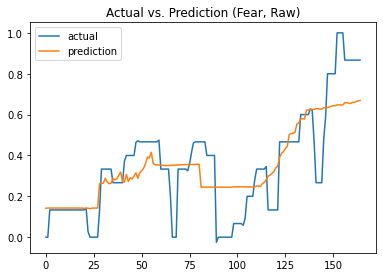

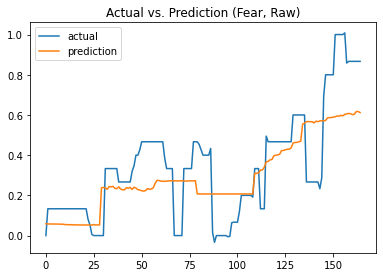

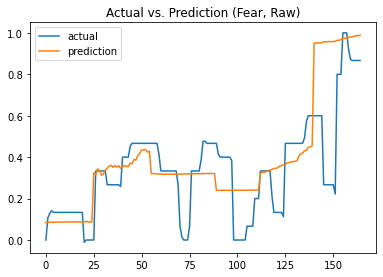

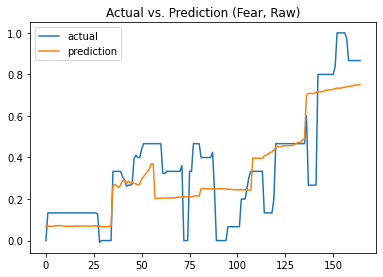

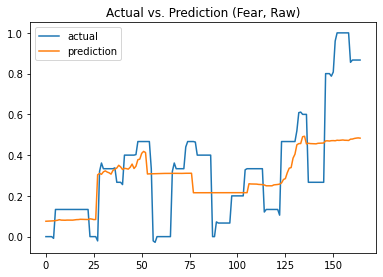

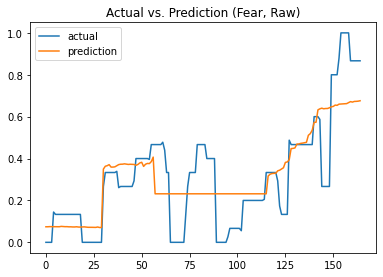

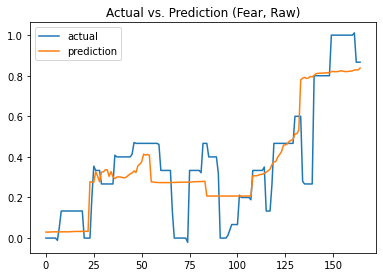

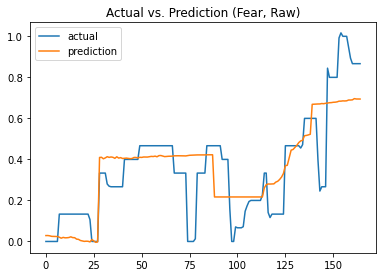

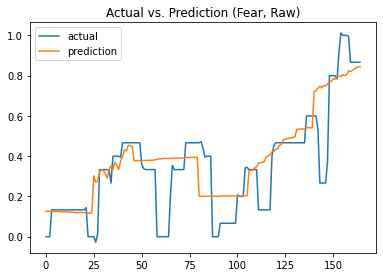

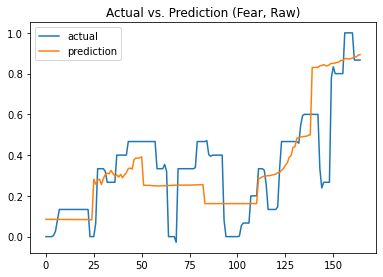

In [81]:
#train model with kfold validation
kfold_splits = 10
epochs = 10
batch_size = 4

x = bci_feature_data
y = questionnaire_data

graph_fold_results = True

kFold = KFold(n_splits=10, shuffle=True)

print('---------- CROSS FOLD VALIDATION ----------\n')

loss_arr = []
score_arr = []
time_arr = []

fold_num = 1
for train, test in kFold.split(x, y):
    model = build_model(num_features * bci_channel_count)

    print(f'---------------------- FOLD NO {fold_num} TRAINING BEGIN ----------------------\n')

    start_time = time.time()

    model.fit(x[train], y[train], batch_size=batch_size, epochs=epochs)
    scores = model.evaluate(x[test], y[test])

    end_time = time.time()

    loss_arr.append(scores[0])
    score_arr.append(scores[1])
    time_arr.append(end_time - start_time)

    print(f'---------------------- FOLD NO {fold_num} TRAINING END ----------------------\n')

    if not graph_fold_results:
        continue

    test_pred = model.predict(x[test])

    fold_results_fig = plt.figure()
    ax = fold_results_fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.set_title(f"Actual vs. Prediction ({data_name}, {'Encoded' if use_bci_features else 'Raw'})")

    ax.plot(np.arange(y[test].shape[0]), y[test], label="actual")
    ax.plot(np.arange(test_pred.shape[0]), test_pred, label="prediction")
    ax.legend()

    fold_num += 1

print('------------ RESULTS PER FOLD ------------')
for i in range(len(loss_arr)):
    print(f'fold #{i}. Loss: {loss_arr[i]:.6f} - Score: {score_arr[i]:.6f} - Training Time: {time_arr[i]:.6f}s')
    print('--------------')

print('\n------- AVG ACROSS FOLDS -------')
print(f'Avg loss: {np.mean(loss_arr):.6f} +/- {np.std(loss_arr):.6f}')
print(f'Avg score: {np.mean(score_arr):.6f} +/- {np.std(score_arr):.6f}')
print(f'Avg training time: {np.mean(time_arr):.6f}s +/- {np.std(time_arr):.6f}s\n')